# Ensemble Learning - The Power of Many

## Introduction

Imagine you're building an image classifier for everyday objects - cars, planes, cats, dogs. No single model gets everything right. Some models are better at distinguishing animals, others excel at vehicles. What if we could combine their strengths?

This notebook demonstrates ensemble learning using **CIFAR-10**, a dataset of 32×32 color images across 10 common categories. Through hands-on experiments with real data, we'll see why combining multiple models often outperforms any individual model.

### The Core Principle: Wisdom of Crowds

The fundamental insight behind ensemble learning is that combining multiple imperfect predictions often yields better results than any single prediction. Different models make different mistakes that tend to cancel out when combined.

Mathematically, if we have $M$ independent models with error rate $\epsilon < 0.5$, the ensemble error rate through majority voting is:

 $$P(\text{ensemble error}) = \sum_{k=\lceil M/2 \rceil}^{M} \binom{M}{k} \epsilon^k (1-\epsilon)^{M-k}$$

 As $M$ increases and $\epsilon < 0.5$, this probability decreases exponentially - turning many weak learners into a strong learner.

## Learning Objectives

By the end of this notebook, you will be able to:

1. Explain why ensemble methods often outperform single models through practical examples
2. Implement Random Forests and understand how bootstrap aggregating reduces overfitting
3. Apply boosting algorithms (AdaBoost and Gradient Boosting) and identify when they excel
4. Quantify prediction uncertainty using deep ensembles and decompose it into epistemic and aleatoric components
5. Detect out-of-distribution samples using ensemble disagreement metrics
6. Select appropriate ensemble methods for different real-world scenarios based on computational and performance trade-offs



In [1]:
%pip install --quiet scikit-image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from scipy import stats
try:
    from skimage.feature import hog as skimage_hog
except Exception:
    skimage_hog = None
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import ipywidgets as widgets

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
plt.style.use('seaborn-v0_8-darkgrid')

Note: you may need to restart the kernel to use updated packages.
Using device: cpu


## Part 1: Understanding Ensemble Concepts with 2D Data

Before diving into image classification, let's visualize core ensemble concepts using simple 2D data where we can actually see decision boundaries.

### Creating a Challenging 2D Dataset

Demo difficulty: medium | noise=0.35, n_estimators=15, max_depth=3, min_samples_leaf=10


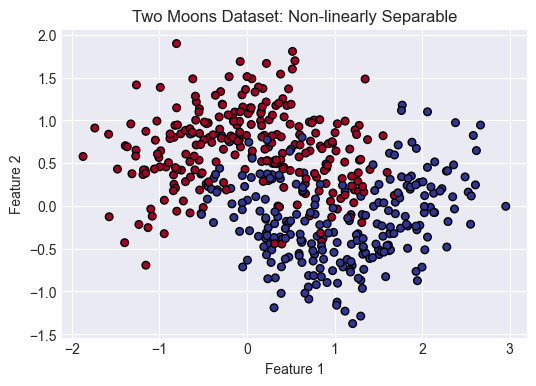

In [2]:
def create_2d_dataset(n_samples=500, noise=0.3):
    """Create a non-linearly separable 2D dataset"""
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    return X, y

def visualize_decision_boundaries(X, y, models, titles):
    """Visualize decision boundaries for multiple models"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
    if len(models) == 1:
        axes = [axes]
    
    for idx, (model, title) in enumerate(zip(models, titles)):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
        axes[idx].scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                         edgecolors='black', s=20)
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Feature 1')
        axes[idx].set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()

def get_demo_difficulty(level='medium'):
    """Return configuration for demo difficulty.
    Levels: 'easy', 'medium', 'hard'
    """
    level = level.lower()
    presets = {
        'easy': {
            'noise': 0.2,
            'n_estimators': 10,
            'max_depth': 4,
            'min_samples_leaf': 5,
            'splitter': 'random',
            'bootstrap_fraction': 0.7,
        },
        'medium': {
            'noise': 0.35,
            'n_estimators': 15,
            'max_depth': 3,
            'min_samples_leaf': 10,
            'splitter': 'random',
            'bootstrap_fraction': 0.8,
        },
        'hard': {
            'noise': 0.5,
            'n_estimators': 25,
            'max_depth': 2,
            'min_samples_leaf': 20,
            'splitter': 'random',
            'bootstrap_fraction': 0.8,
        },
    }
    return presets.get(level, presets['medium'])

# Create and visualize the dataset with adjustable difficulty
DEMO_DIFFICULTY = 'medium'  # change to 'easy' or 'hard'
cfg = get_demo_difficulty(DEMO_DIFFICULTY)
print(f"Demo difficulty: {DEMO_DIFFICULTY} | noise={cfg['noise']}, n_estimators={cfg['n_estimators']}, "
      f"max_depth={cfg['max_depth']}, min_samples_leaf={cfg['min_samples_leaf']}")

X_2d, y_2d = create_2d_dataset(n_samples=500, noise=cfg['noise'])
X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(
    X_2d, y_2d, test_size=0.3, random_state=42
)

plt.figure(figsize=(6, 4))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap='RdYlBu', edgecolors='black', s=30)
plt.title('Two Moons Dataset: Non-linearly Separable')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Demonstrating Ensemble Power with Decision Boundaries

Training weak decision trees (bagged, random splits):
  Tree 1: Accuracy = 0.693
  Tree 2: Accuracy = 0.767
  Tree 3: Accuracy = 0.700
  Tree 4: Accuracy = 0.753
  Tree 5: Accuracy = 0.707
  Tree 6: Accuracy = 0.653
  Tree 7: Accuracy = 0.813
  Tree 8: Accuracy = 0.787
  Tree 9: Accuracy = 0.807
  Tree 10: Accuracy = 0.840
  Tree 11: Accuracy = 0.720
  Tree 12: Accuracy = 0.647
  Tree 13: Accuracy = 0.767
  Tree 14: Accuracy = 0.713
  Tree 15: Accuracy = 0.713

Ensemble (majority vote): Accuracy = 0.820
Improvement over average: +0.081


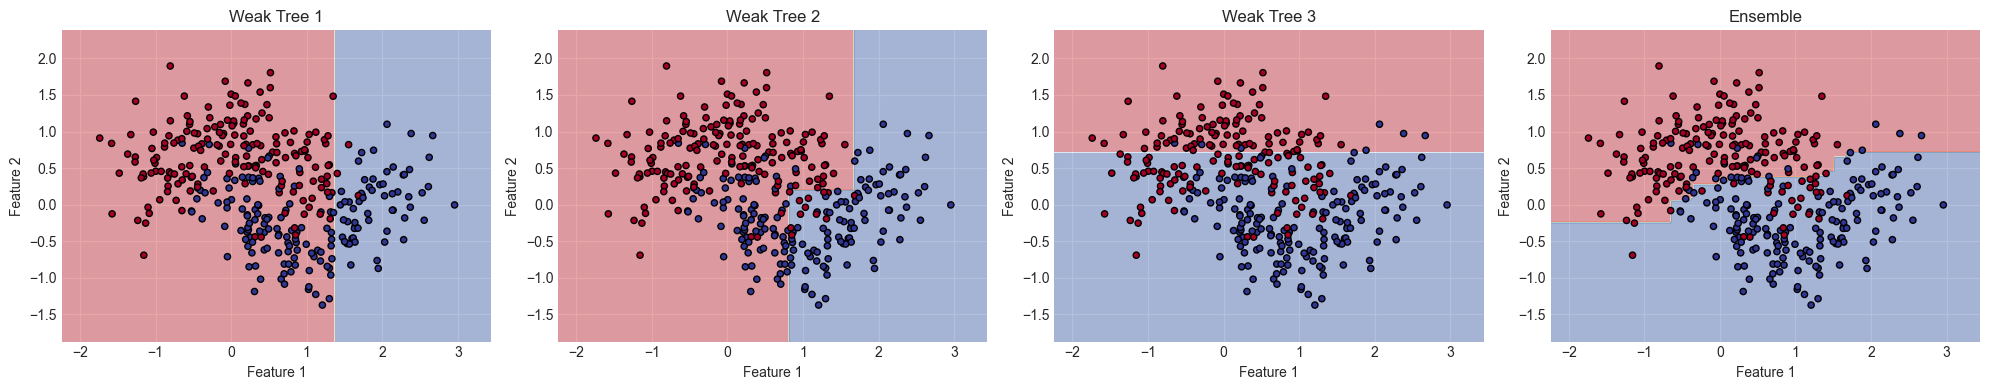

In [3]:
def demonstrate_ensemble_concept(
    X_train, y_train, X_test, y_test,
    n_estimators=15,
    max_depth=3,
    min_samples_leaf=10,
    splitter='random',
    bagging=True,
    bootstrap_fraction=1.0,
    random_state=42,
    verbose=True,
):
    """Show how ensemble combines weak learners with adjustable difficulty."""
    
    # Train multiple weak learners
    weak_learners = []
    test_scores = []
    
    if verbose:
        print("Training weak decision trees (bagged, random splits):")
    n_samples = X_train.shape[0]
    for i in range(n_estimators):
        # Bootstrap sample indices for bagging
        if bagging:
            boot_size = max(1, int(n_samples * bootstrap_fraction))
            boot_idx = np.random.choice(n_samples, size=boot_size, replace=True)
            X_boot, y_boot = X_train[boot_idx], y_train[boot_idx]
        else:
            X_boot, y_boot = X_train, y_train
        # Randomized and slightly weaker trees to increase diversity
        clf = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            splitter=splitter,
            random_state=i * random_state,
        )
        clf.fit(X_boot, y_boot)
        weak_learners.append(clf)
        score = accuracy_score(y_test, clf.predict(X_test))
        test_scores.append(score)
        if verbose:
            print(f"  Tree {i+1}: Accuracy = {score:.3f}")
    
    # Create ensemble predictor
    class SimpleEnsemble:
        def __init__(self, models):
            self.models = models
        
        def predict(self, X):
            predictions = np.array([model.predict(X) for model in self.models])
            return stats.mode(predictions, axis=0)[0].flatten()
    
    ensemble = SimpleEnsemble(weak_learners)
    ensemble_score = accuracy_score(y_test, ensemble.predict(X_test))
    
    if verbose:
        print(f"\nEnsemble (majority vote): Accuracy = {ensemble_score:.3f}")
        print(f"Improvement over average: +{ensemble_score - np.mean(test_scores):.3f}")
    
    # Visualize decision boundaries
    models_to_viz = weak_learners[:3] + [ensemble]
    titles = [f'Weak Tree {i+1}' for i in range(3)] + ['Ensemble']
    visualize_decision_boundaries(X_train, y_train, models_to_viz, titles)
    
    return weak_learners, ensemble

weak_models_2d, ensemble_2d = demonstrate_ensemble_concept(
    X_2d_train, y_2d_train, X_2d_test, y_2d_test,
    n_estimators=cfg['n_estimators'],
    max_depth=cfg['max_depth'],
    min_samples_leaf=cfg['min_samples_leaf'],
    splitter=cfg['splitter'],
    bagging=True,
    bootstrap_fraction=cfg['bootstrap_fraction'],
    random_state=42,
)

**Key Insights from Visualization:**
- Individual weak learners create simple, axis-aligned decision boundaries
- Each captures different aspects of the curved decision boundary
- The ensemble combines these simple boundaries into a more complex, accurate boundary
- This is the essence of ensemble learning: simple models → complex decisions


### Interactive Demo: Adjust Difficulty and Model Settings

In [4]:
def interactive_ensemble_widget():
    """Render an interactive widget to explore ensemble behavior on 2D data."""
    # Controls
    noise = widgets.FloatSlider(value=cfg['noise'], min=0.0, max=0.6, step=0.05, description='Noise', readout_format='.2f')
    n_estimators = widgets.IntSlider(value=cfg['n_estimators'], min=1, max=100, step=1, description='Estimators')
    max_depth = widgets.IntSlider(value=cfg['max_depth'], min=1, max=10, step=1, description='Max depth')
    min_leaf = widgets.IntSlider(value=cfg['min_samples_leaf'], min=1, max=50, step=1, description='Min leaf')
    boot_frac = widgets.FloatSlider(value=cfg['bootstrap_fraction'], min=0.1, max=1.0, step=0.05, description='Boot frac', readout_format='.2f')
    bagging = widgets.Checkbox(value=True, description='Bagging')

    out = widgets.Output()

    def run_demo(change=None):
        with out:
            out.clear_output(wait=True)
            # Recreate data
            X, y = create_2d_dataset(n_samples=500, noise=noise.value)
            X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)

            # Run demo (suppress internal prints)
            weak_models, _ = demonstrate_ensemble_concept(
                X_tr, y_tr, X_te, y_te,
                n_estimators=n_estimators.value,
                max_depth=max_depth.value,
                min_samples_leaf=min_leaf.value,
                splitter='random',
                bagging=bagging.value,
                bootstrap_fraction=boot_frac.value,
                random_state=42,
                verbose=False,
            )

            # Compute and display concise metrics
            preds = np.array([m.predict(X_te) for m in weak_models])
            ens_pred = stats.mode(preds, axis=0)[0].flatten()
            ind_acc = [accuracy_score(y_te, p) for p in preds]
            ens_acc = accuracy_score(y_te, ens_pred)
            print(f"Individual avg: {np.mean(ind_acc):.3f} | Ensemble: {ens_acc:.3f} | Improvement: {ens_acc - np.mean(ind_acc):+.3f}")

    # Wire events
    for w in [noise, n_estimators, max_depth, min_leaf, boot_frac, bagging]:
        w.observe(run_demo, names='value')

    controls = widgets.VBox([
        widgets.HBox([noise, n_estimators]),
        widgets.HBox([max_depth, min_leaf]),
        widgets.HBox([boot_frac, bagging]),
    ])

    display(controls, out)
    run_demo()

# Display the widget
interactive_ensemble_widget()

Output()

## Part 2: Loading and Understanding CIFAR-10

Now let's work with real image data. CIFAR-10 contains 60,000 32×32 color images across 10 classes.

### Loading CIFAR-10 Dataset

In [5]:
def load_cifar10(num_train=5000, num_test=1000):
    """
    Load CIFAR-10 with specified number of samples
    Using subset for faster training in educational setting
    """
    print("Loading CIFAR-10 dataset...")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load full datasets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    
    # CIFAR-10 classes
    classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Take subset for faster training
    train_indices = np.random.choice(len(trainset), num_train, replace=False)
    test_indices = np.random.choice(len(testset), num_test, replace=False)
    
    # Extract images and labels
    train_subset = torch.utils.data.Subset(trainset, train_indices)
    test_subset = torch.utils.data.Subset(testset, test_indices)
    train_loader = DataLoader(
        train_subset, batch_size=num_train, shuffle=False,
        num_workers=2, pin_memory=torch.cuda.is_available()
    )
    test_loader = DataLoader(
        test_subset, batch_size=num_test, shuffle=False,
        num_workers=2, pin_memory=torch.cuda.is_available()
    )
    
    # Get subset
    X_train, y_train = [], []
    for i, (images, labels) in enumerate(train_loader):
        if i == 0:  # Just get first batch
            X_train = images.numpy()
            y_train = labels.numpy()
            break
    
    X_test, y_test = [], []
    for i, (images, labels) in enumerate(test_loader):
        if i == 0:
            X_test = images.numpy()
            y_test = labels.numpy()
            break
    
    # Subsets already applied via DataLoaders above
    
    print(f"Loaded {len(X_train)} training images and {len(X_test)} test images")
    print(f"Image shape: {X_train[0].shape}")
    print(f"Classes: {', '.join(classes)}")
    
    return X_train, y_train, X_test, y_test, classes

# Load the data (reduced subset sizes for speed)
X_train_imgs, y_train, X_test_imgs, y_test, class_names = load_cifar10(num_train=4000, num_test=1000)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Loaded 4000 training images and 1000 test images
Image shape: (3, 32, 32)
Classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


### Visualizing CIFAR-10 Images

Let's examine actual images to understand the classification challenges. Despite being only 32×32 pixels, these images contain enough information for classification, though some are quite ambiguous.


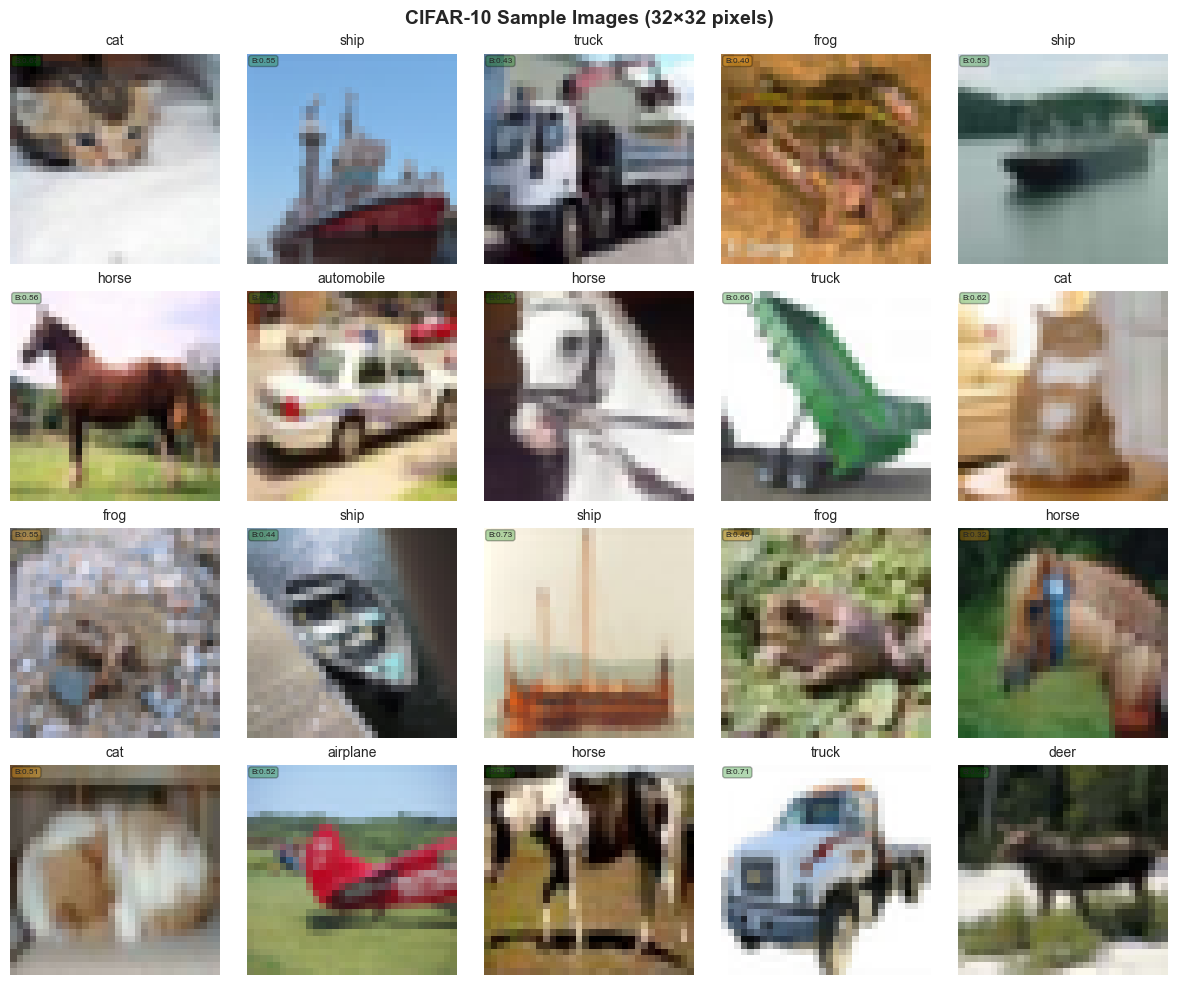

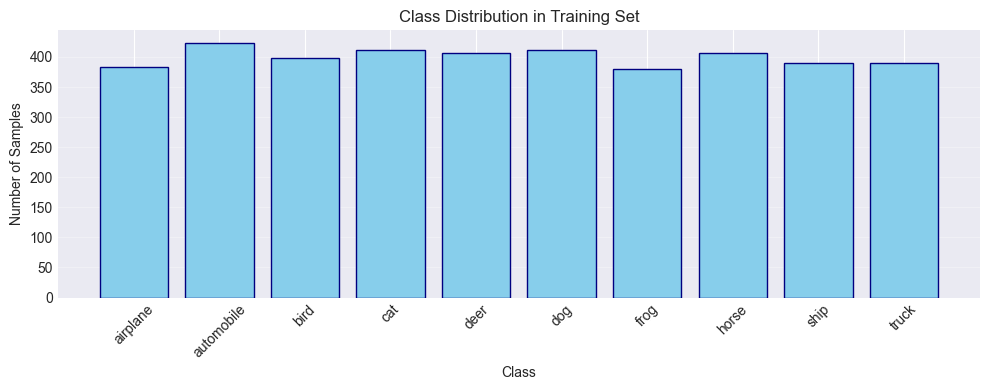

In [6]:
def visualize_cifar_samples(X, y, class_names, n_samples=20):
    """Visualize sample images from CIFAR-10"""
    
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    axes = axes.ravel()
    
    # Select random samples
    indices = np.random.choice(len(X), n_samples, replace=False)
    
    for idx, ax_idx in enumerate(range(n_samples)):
        img_idx = indices[idx]
        
        # Denormalize image for display
        img = X[img_idx]
        img = img.transpose((1, 2, 0))  # CHW to HWC
        img = img * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        
        axes[ax_idx].imshow(img)
        axes[ax_idx].set_title(f'{class_names[y[img_idx]]}', fontsize=10)
        axes[ax_idx].axis('off')
        
        # Add quality indicator (brightness/contrast)
        brightness = np.mean(img)
        contrast = np.std(img)
        quality_color = 'green' if contrast > 0.2 else 'orange'
        
        axes[ax_idx].text(0.02, 0.98, f'B:{brightness:.2f}',
                         transform=axes[ax_idx].transAxes,
                         bbox=dict(boxstyle='round', facecolor=quality_color, alpha=0.3),
                         verticalalignment='top', fontsize=6)
    
    plt.suptitle('CIFAR-10 Sample Images (32×32 pixels)', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 4))
    plt.bar([class_names[i] for i in unique], counts, color='skyblue', edgecolor='navy')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Set')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_cifar_samples(X_train_imgs, y_train, class_names)

**Observations about CIFAR-10:**
- Images are small (32×32) but recognizable
- Some images are clear (high contrast), others are ambiguous
- Certain class pairs are easily confused (cat/dog, truck/automobile)
- This natural ambiguity makes it perfect for demonstrating ensemble benefits


### Feature Extraction for Classical ML (and ResNet embeddings)

Classical ML algorithms need fixed-size feature vectors. We'll extract simple but effective features from the images.


In [7]:
def extract_features_from_images(images, add_hog=True):
    """
    Extract features suitable for Random Forest and Boosting
    Simpler than the iWildCam version but effective for CIFAR-10
    """
    features = []
    
    print(f"Extracting features from {len(images)} images...")
    
    for img in images:
        feature_vector = []
        
        # Image is in CHW format, normalized
        # Denormalize for feature extraction
        img = img * 0.5 + 0.5
        
        # 1. Color channel statistics (3 channels × 5 stats = 15 features)
        for channel in range(3):
            channel_data = img[channel].flatten()
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.min(channel_data),
                np.max(channel_data),
                np.median(channel_data)
            ])
        
        # 2. Color histograms (3 channels × 8 bins = 24 features)
        for channel in range(3):
            hist, _ = np.histogram(img[channel].flatten(), bins=8, range=(0, 1))
            feature_vector.extend(hist / (hist.sum() + 1e-6))
        
        # 3. Edge features (gradient magnitudes)
        gray = np.mean(img, axis=0)  # Convert to grayscale
        if gray.shape[0] > 1 and gray.shape[1] > 1:
            dy, dx = np.gradient(gray)
            feature_vector.extend([
                np.mean(np.abs(dx)),
                np.mean(np.abs(dy)),
                np.std(np.abs(dx)),
                np.std(np.abs(dy))
            ])
        else:
            feature_vector.extend([0, 0, 0, 0])
        
        # 4. Texture: Local Binary Pattern-like features (simplified)
        # Divide image into 4 quadrants
        h, w = gray.shape
        for i in range(2):
            for j in range(2):
                region = gray[i*h//2:(i+1)*h//2, j*w//2:(j+1)*w//2]
                if region.size > 0:
                    feature_vector.extend([
                        np.mean(region),
                        np.std(region)
                    ])
                else:
                    feature_vector.extend([0, 0])

        # 5. HOG features (Histogram of Oriented Gradients)
        if add_hog and skimage_hog is not None:
            # Use standard parameters suitable for 32x32 images
            # This yields a compact yet descriptive descriptor
            hog_vec = skimage_hog(
                gray,
                orientations=8,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                feature_vector=True,
            )
            feature_vector.extend(hog_vec)
        
        features.append(feature_vector)
    
    features = np.array(features, dtype=np.float32)
    
    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    print(f"Feature shape: {features.shape}")
    return features, scaler

def get_resnet_feature_extractor(model_name='resnet18', device='cpu'):
    """Load a pretrained ResNet and return a model that outputs embeddings."""
    if model_name == 'resnet18':
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        embedding_dim = 512
    elif model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
        embedding_dim = 2048
    else:
        raise ValueError("Unsupported model_name. Use 'resnet18' or 'resnet50'.")
    # Replace classifier with identity to get penultimate features
    model.fc = torch.nn.Identity()
    model.eval()
    model.to(device)
    return model, embedding_dim

def extract_resnet_features(images, model_name='resnet18', device='cpu', batch_size=128):
    """Extract ImageNet-pretrained ResNet embeddings from CIFAR images.
    images: numpy array (N, C, H, W) in [-1, 1] due to earlier Normalize(0.5, 0.5).
    """
    model, embedding_dim = get_resnet_feature_extractor(model_name, device)
    N = len(images)
    feats = np.zeros((N, embedding_dim), dtype=np.float32)

    # ImageNet normalization
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            x = torch.from_numpy(images[start:end]).float().to(device)
            # Denormalize from [-1,1] to [0,1]
            x = x * 0.5 + 0.5
            # Resize to 224x224 for ResNet
            x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            # Normalize to ImageNet stats
            x = (x - mean) / std
            out = model(x)
            feats[start:end] = out.detach().cpu().numpy()

    scaler = StandardScaler()
    feats = scaler.fit_transform(feats)
    return feats, scaler

# Feature extraction configuration
USE_RESNET_FEATURES = True  # set False to use handcrafted (HOG) features
RESNET_MODEL_NAME = 'resnet18'  # 'resnet18' or 'resnet50'

# Extract features
if USE_RESNET_FEATURES:
    print(f"Using ResNet features: {RESNET_MODEL_NAME}")
    X_train, scaler = extract_resnet_features(X_train_imgs, model_name=RESNET_MODEL_NAME, device=device, batch_size=128)
    X_test, _ = extract_resnet_features(X_test_imgs, model_name=RESNET_MODEL_NAME, device=device, batch_size=128)
    X_test = scaler.transform(X_test)
else:
    X_train, scaler = extract_features_from_images(X_train_imgs, add_hog=True)
    X_test, _ = extract_features_from_images(X_test_imgs, add_hog=True)
    X_test = scaler.transform(X_test)

print(f"\nDataset ready for classical ML:")
print(f"  Training: {X_train.shape}")
print(f"  Testing: {X_test.shape}")
print(f"  Number of classes: {len(class_names)}")

Using ResNet features: resnet18

Dataset ready for classical ML:
  Training: (4000, 512)
  Testing: (1000, 512)
  Number of classes: 10


**Feature Engineering Notes:**
- Two modes:
  - Handcrafted (color stats + hist + edges + texture + optional HOG ~300 dims)
  - ResNet embeddings (resnet18=512 dims, resnet50=2048 dims)
- Handcrafted features are fast but less expressive; ResNet embeddings are stronger and boost tree ensembles
- All features are standardized before training

## Part 3: Why Ensembles? Single Models vs. Many

### The Problem with Single Models

Let's first see how individual models perform and their limitations.

Training single decision trees:
  Shallow Tree (depth=3): Train=0.418, Test=0.217, Gap=0.201
  Medium Tree (depth=8): Train=0.719, Test=0.276, Gap=0.443
  Deep Tree (unlimited): Train=1.000, Test=0.265, Gap=0.735


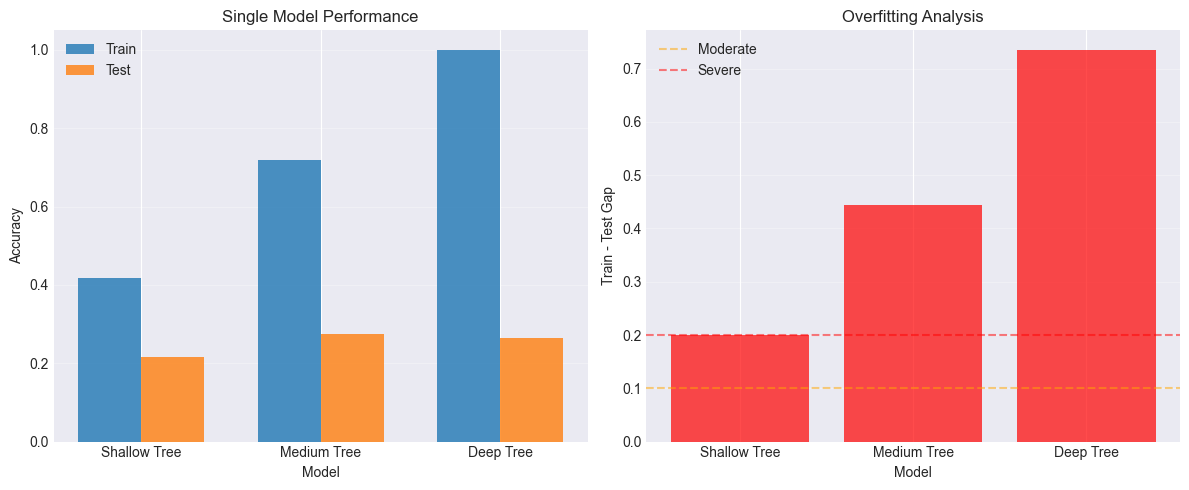

In [8]:
def analyze_single_model_limitations(X_train, y_train, X_test, y_test):
    """Demonstrate overfitting and underfitting in single models"""
    
    models = {
        'Shallow Tree (depth=3)': DecisionTreeClassifier(max_depth=3, random_state=42),
        'Medium Tree (depth=8)': DecisionTreeClassifier(max_depth=8, random_state=42),
        'Deep Tree (unlimited)': DecisionTreeClassifier(max_depth=None, random_state=42),
    }
    
    results = []
    
    print("Training single decision trees:")
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))
        gap = train_acc - test_acc
        
        results.append({
            'Model': name,
            'Train Acc': train_acc,
            'Test Acc': test_acc,
            'Overfit Gap': gap
        })
        
        print(f"  {name}: Train={train_acc:.3f}, Test={test_acc:.3f}, Gap={gap:.3f}")
    
    results_df = pd.DataFrame(results)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy comparison
    x = np.arange(len(results_df))
    width = 0.35
    ax1.bar(x - width/2, results_df['Train Acc'], width, label='Train', alpha=0.8)
    ax1.bar(x + width/2, results_df['Test Acc'], width, label='Test', alpha=0.8)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Single Model Performance')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.split('(')[0].strip() for m in results_df['Model']])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Overfitting visualization
    colors = ['green' if g < 0.1 else 'orange' if g < 0.2 else 'red' 
             for g in results_df['Overfit Gap']]
    ax2.bar(x, results_df['Overfit Gap'], color=colors, alpha=0.7)
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Train - Test Gap')
    ax2.set_title('Overfitting Analysis')
    ax2.set_xticks(x)
    ax2.set_xticklabels([m.split('(')[0].strip() for m in results_df['Model']])
    ax2.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Moderate')
    ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Severe')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

single_model_results = analyze_single_model_limitations(X_train, y_train, X_test, y_test)

**Key Problems with Single Models:**
- **Shallow models** underfit - can't capture complex patterns
- **Deep models** overfit - memorize training data
- Finding the "sweet spot" is difficult and dataset-dependent
- We need a better approach → **Ensembles!**

### Ensemble Power: Combining Weak Learners

We build many weak decision trees using bagging (bootstrap samples), random feature subspaces, and randomized splits, then combine them by majority vote. We visualize:
- Distribution of individual model accuracies vs the ensemble accuracy
- Pairwise model agreement (how often two models predict the same label)
- Error counts per test sample across models
- “Rescued” examples where the ensemble is correct although most models are wrong

### How we compute agreement and related quantities

Let $M$ be the number of models and $N$ the number of test samples. Let $p_i(k)$ be the prediction of model $i$ on sample $k$, and $y_k$ the ground-truth label.

- Pairwise agreement between models $i$ and $j$:  
  $A_{ij} = \frac{1}{N}\sum_{k=1}^{N}\mathbf{1}\big[p_i(k) = p_j(k)\big]$  
  Lower off-diagonal $A_{ij}$ implies more diversity.

- Ensemble (majority vote) prediction for sample $k$:  
  $\hat{y}^{\text{ens}}_k = \mathrm{mode}\big(\{p_i(k)\}_{i=1}^{M}\big)$

- Individual model accuracy (model $i$):  
  $\mathrm{acc}_i = \frac{1}{N}\sum_{k=1}^{N}\mathbf{1}\big[p_i(k) = y_k\big]$

- Error count per sample (how many models are wrong on $k$):  
  $E_k = \sum_{i=1}^{M}\mathbf{1}\big[p_i(k) \neq y_k\big]$

- “Rescued” examples (ensemble correct while majority is wrong)  

These metrics together quantify diversity (agreement matrix), difficulty (error distribution), and the “wisdom of crowds” effect (ensemble outperforming individuals and rescuing hard cases).

Training 100 trees | depth=12, leaf=2, bagging=True(0.8), feat_frac=0.7, splitter=random

Individual average: 0.311
Ensemble accuracy: 0.634
Improvement: +0.323


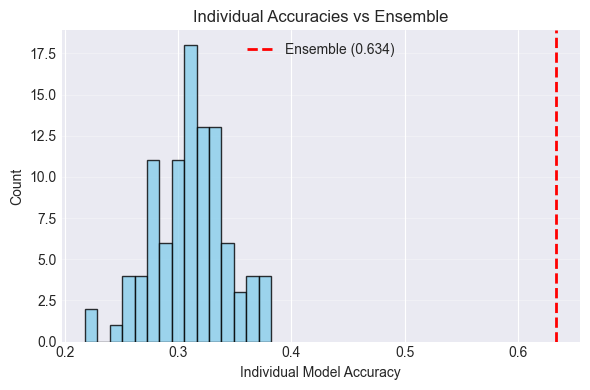

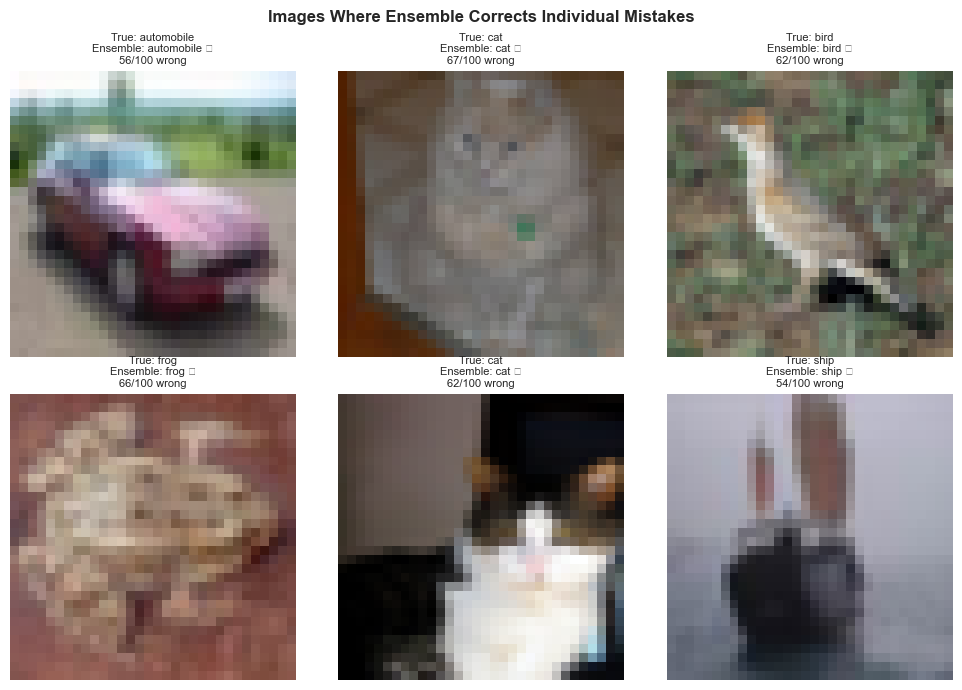

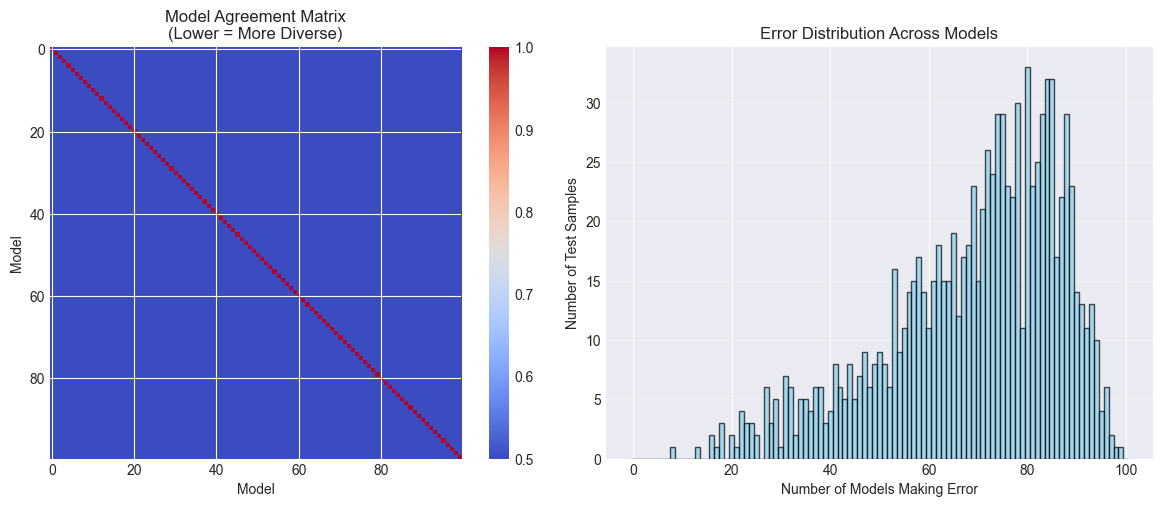

In [9]:
def demonstrate_ensemble_power(
    X_train, y_train, X_test, y_test, X_test_imgs, class_names,
    n_models=100,
    max_depth=12,
    min_samples_leaf=2,
    splitter='random',
    bagging=True,
    bootstrap_fraction=0.8,
    feature_subsample_fraction=0.7,
    random_state=42,
    verbose=False,
):
    """Show how an ensemble of diverse weak trees beats individual models.

    Diversity sources: bootstrap samples + randomized splits + feature subspace.
    """
    
    print(
        f"Training {n_models} trees | depth={max_depth}, leaf={min_samples_leaf}, "
        f"bagging={bagging}({bootstrap_fraction}), feat_frac={feature_subsample_fraction}, splitter={splitter}"
    )
    
    rng = np.random.RandomState(random_state)
    n_samples, n_features = X_train.shape
    n_feat_sub = max(1, int(n_features * feature_subsample_fraction))
    
    weak_models = []
    predictions = []
    
    for i in range(n_models):
        # Bootstrap sampling
        if bagging:
            boot_size = max(1, int(n_samples * bootstrap_fraction))
            boot_idx = rng.choice(n_samples, size=boot_size, replace=True)
        else:
            boot_idx = np.arange(n_samples)
        
        # Feature subspace sampling
        feat_idx = rng.choice(n_features, size=n_feat_sub, replace=False)
        
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            splitter=splitter,
            random_state=random_state * (i + 1),
        )
        model.fit(X_train[boot_idx][:, feat_idx], y_train[boot_idx])
        
        pred = model.predict(X_test[:, feat_idx])
        predictions.append(pred)
        weak_models.append((model, feat_idx))  # store feature indices with model
        
        acc = accuracy_score(y_test, pred)
        if verbose:
            print(f"  Model {i+1}: {acc:.3f}")
    
    # Stack predictions for analysis
    predictions = np.array(predictions)
    
    # Ensemble prediction via majority vote
    ensemble_pred = stats.mode(predictions, axis=0)[0].flatten()
    ensemble_acc = accuracy_score(y_test, ensemble_pred)
    
    individual_accs = [accuracy_score(y_test, p) for p in predictions]
    individual_avg = np.mean(individual_accs)
    
    print(f"\nIndividual average: {individual_avg:.3f}")
    print(f"Ensemble accuracy: {ensemble_acc:.3f}")
    print(f"Improvement: +{ensemble_acc - individual_avg:.3f}")
    
    # Histogram of individual accuracies with ensemble marker
    #   The histogram shows the spread of individual tree accuracies.
    #   The red dashed line marks the ensemble accuracy.
    #   A clear rightward gap between the ensemble line and the bulk of the histogram is evidence of “wisdom of crowds” 
    #      — voting reduces variance and corrects many individual mistakes.

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(individual_accs, bins=15, color='skyblue', edgecolor='black', alpha=0.8)
    ax.axvline(ensemble_acc, color='red', linestyle='--', linewidth=2, label=f'Ensemble ({ensemble_acc:.3f})')
    ax.set_xlabel('Individual Model Accuracy')
    ax.set_ylabel('Count')
    ax.set_title('Individual Accuracies vs Ensemble')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Analyze where ensemble helps most
    individual_errors = np.sum(predictions != y_test, axis=0)
    ensemble_correct = ensemble_pred == y_test
    
    # Find cases where ensemble corrects majority mistakes
    rescued_mask = (individual_errors > n_models/2) & ensemble_correct
    rescued_indices = np.where(rescued_mask)[0][:6]
    
    if len(rescued_indices) > 0:
        # Visualize rescued cases
        #   These are qualitative illustrations where majority vote beats most individuals.
        #   Even when many trees are wrong for the same sample, the ensemble can correct the prediction 
        #     if enough trees make different (and correct) mistakes, i.e., errors are not perfectly correlated.

        fig, axes = plt.subplots(2, 3, figsize=(10, 7))
        axes = axes.ravel()
        
        for idx, test_idx in enumerate(rescued_indices[:6]):
            img = X_test_imgs[test_idx].transpose((1, 2, 0))
            img = img * 0.5 + 0.5  # Denormalize
            img = np.clip(img, 0, 1)
            
            axes[idx].imshow(img)
            
            # Count predictions for this image
            pred_counts = np.bincount(predictions[:, test_idx])
            top_pred = np.argmax(pred_counts)
            
            title = f"True: {class_names[y_test[test_idx]]}\n"
            title += f"Ensemble: {class_names[ensemble_pred[test_idx]]} ✓\n"
            title += f"{individual_errors[test_idx]}/{n_models} wrong"
            
            axes[idx].set_title(title, fontsize=8)
            axes[idx].axis('off')
        
        plt.suptitle('Images Where Ensemble Corrects Individual Mistakes', fontsize=12, weight='bold')
        plt.tight_layout()
        plt.show()
    
    # Visualize prediction diversity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Agreement heatmap
    #   Model agreement matrix:
    #     Each cell (i, j) shows how often two models make the same prediction.
    #     Off-diagonal values well below 1 (e.g., ~0.6–0.8 rather than ~0.95–1.0) indicate healthy diversity. 
    #     If off-diagonals are too high, models are too similar and the ensemble brings little benefit.

    agreement_matrix = np.zeros((n_models, n_models))
    for i in range(n_models):
        for j in range(n_models):
            agreement_matrix[i, j] = np.mean(predictions[i] == predictions[j])
    
    im = ax1.imshow(agreement_matrix, cmap='coolwarm', vmin=0.5, vmax=1)
    ax1.set_title('Model Agreement Matrix\n(Lower = More Diverse)')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Model')
    plt.colorbar(im, ax=ax1)
    
    # Error distribution across models:
    #   The x-axis is “how many models misclassified this test sample.”
    #   Mass concentrated well below n_models/2 means many samples are “easy” (most models are correct), making the ensemble robust.
    #   A tail towards the right represents hard/ambiguous samples; the ensemble can still succeed if enough models disagree in the right way.

    ax2.hist(individual_errors, bins=np.arange(n_models+2)-0.5, 
            color='skyblue', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Number of Models Making Error')
    ax2.set_ylabel('Number of Test Samples')
    ax2.set_title('Error Distribution Across Models')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return weak_models, ensemble_pred

weak_models, ensemble_predictions = demonstrate_ensemble_power(
    X_train, y_train, X_test, y_test, X_test_imgs, class_names
)

**Critical Insights:**
- Individual weak models vary in performance; diversity is essential
- Majority voting substantially boosts accuracy compared to single models
- Models exhibit non-perfect agreement, indicating healthy diversity
- The ensemble often corrects cases where many individuals fail ("wisdom of crowds")

## Part 4: Random Forests - Bagging in Action

### Understanding Random Forests

Random Forests combine two key ideas:
1. **Bootstrap Aggregating (Bagging)**: Each tree sees different training samples
2. **Feature Randomness**: Each split considers only $\sqrt{p}$ random features

This creates diverse trees that collectively form a robust predictor:
$$\text{RF}(x) = \frac{1}{T}\sum_{t=1}^{T} h_t(x, \Theta_t)$$

where $h_t$ is tree $t$ with random parameters $\Theta_t$.

### Bootstrap Sampling Analysis

We will visualize three panels in one row:
- Sample usage across trees (heatmap)
- OOB rate histogram with theory line
- Feature randomness (random subspace) heatmap

Note on OOB rate: for a given sample, its OOB rate is the fraction of trees
in which it was not selected by the bootstrap. For bootstrap size $n$ with
sampling with replacement, the probability a sample is not selected in one
tree is $(1 - 1/n)^n \to e^{-1} \approx 0.368$ as $n \to \infty$.


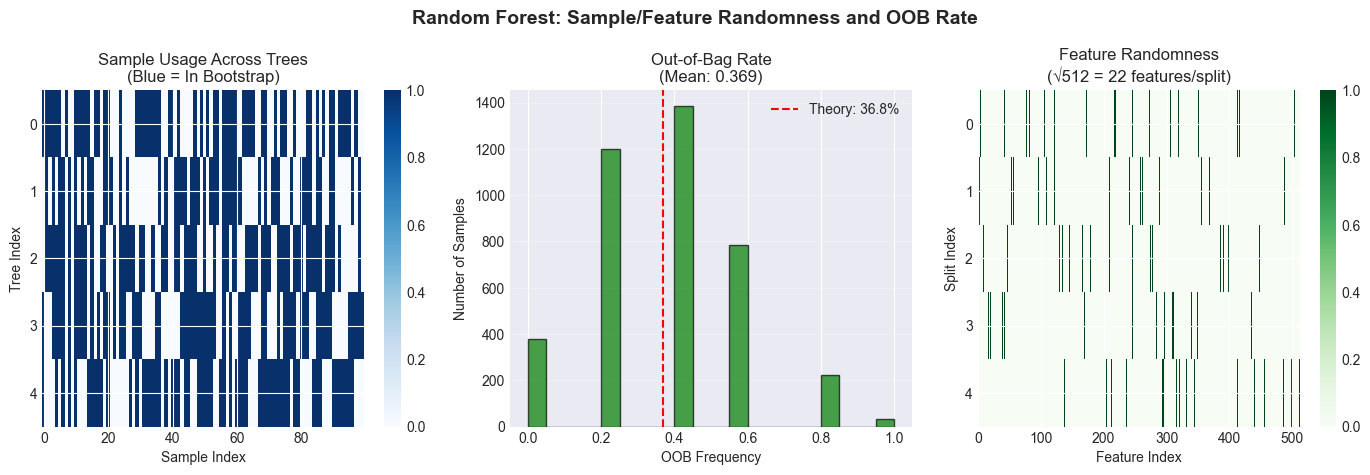

In [18]:
def analyze_bootstrap_mechanics(X_train, y_train):
    """Demonstrate bootstrap sampling and OOB samples"""
    
    n_samples = len(X_train)
    n_trees = 5
    
    # Single-row layout with three panels
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.8))
    
    # Track sample usage
    sample_usage = np.zeros((n_trees, min(100, n_samples)))
    oob_counts = np.zeros(n_samples)
    
    for tree_idx in range(n_trees):
        # Create bootstrap sample
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        unique_indices = np.unique(bootstrap_indices)
        
        # Mark OOB samples
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[unique_indices] = False
        oob_counts[oob_mask] += 1
        
        # Track usage for visualization
        for idx in unique_indices:
            if idx < 100:
                sample_usage[tree_idx, idx] = 1
    
    # Sample usage heatmap
    ax = axes[0]
    im = ax.imshow(sample_usage, aspect='auto', cmap='Blues', interpolation='nearest')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Tree Index')
    ax.set_title('Sample Usage Across Trees\n(Blue = In Bootstrap)')
    plt.colorbar(im, ax=ax)
    
    # OOB frequency
    ax = axes[1]
    oob_rate = oob_counts / n_trees
    ax.hist(oob_rate, bins=20, color='green', edgecolor='black', alpha=0.7)
    ax.axvline(0.368, color='red', linestyle='--', label='Theory: 36.8%')
    ax.set_xlabel('OOB Frequency')
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Out-of-Bag Rate\n(Mean: {np.mean(oob_rate):.3f})')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Feature bagging visualization
    ax = axes[2]
    n_features = X_train.shape[1]
    sqrt_features = int(np.sqrt(n_features))
    
    feature_usage = np.zeros((5, n_features))
    for i in range(5):
        selected = np.random.choice(n_features, sqrt_features, replace=False)
        feature_usage[i, selected] = 1
    
    im = ax.imshow(feature_usage, aspect='auto', cmap='Greens', interpolation='nearest')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Split Index')
    ax.set_title(f'Feature Randomness\n(√{n_features} = {sqrt_features} features/split)')
    plt.colorbar(im, ax=ax)
    
    plt.suptitle('Random Forest: Sample/Feature Randomness and OOB Rate', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

analyze_bootstrap_mechanics(X_train, y_train)

### Why Random Forests Work (diversity summary)
- Different samples (bootstrap) → lower correlation between trees
- Different features (random subspace) → diverse split candidates
- Randomized tie-breaking/stochasticity → additional decorrelation
- Majority voting reduces variance; OOB samples enable internal validation

### Training Random Forest with Analysis

Training Random Forests with increasing trees...
  n_trees=  1: Test=0.253, OOB=0.219, Time=0.13s
  n_trees=  5: Test=0.352, OOB=0.427, Time=0.36s
  n_trees= 10: Test=0.458, OOB=0.530, Time=0.20s
  n_trees= 25: Test=0.531, OOB=0.653, Time=0.48s
  n_trees= 50: Test=0.590, OOB=0.715, Time=0.77s
  n_trees=100: Test=0.626, OOB=0.750, Time=1.57s
  n_trees=200: Test=0.649, OOB=0.773, Time=3.21s


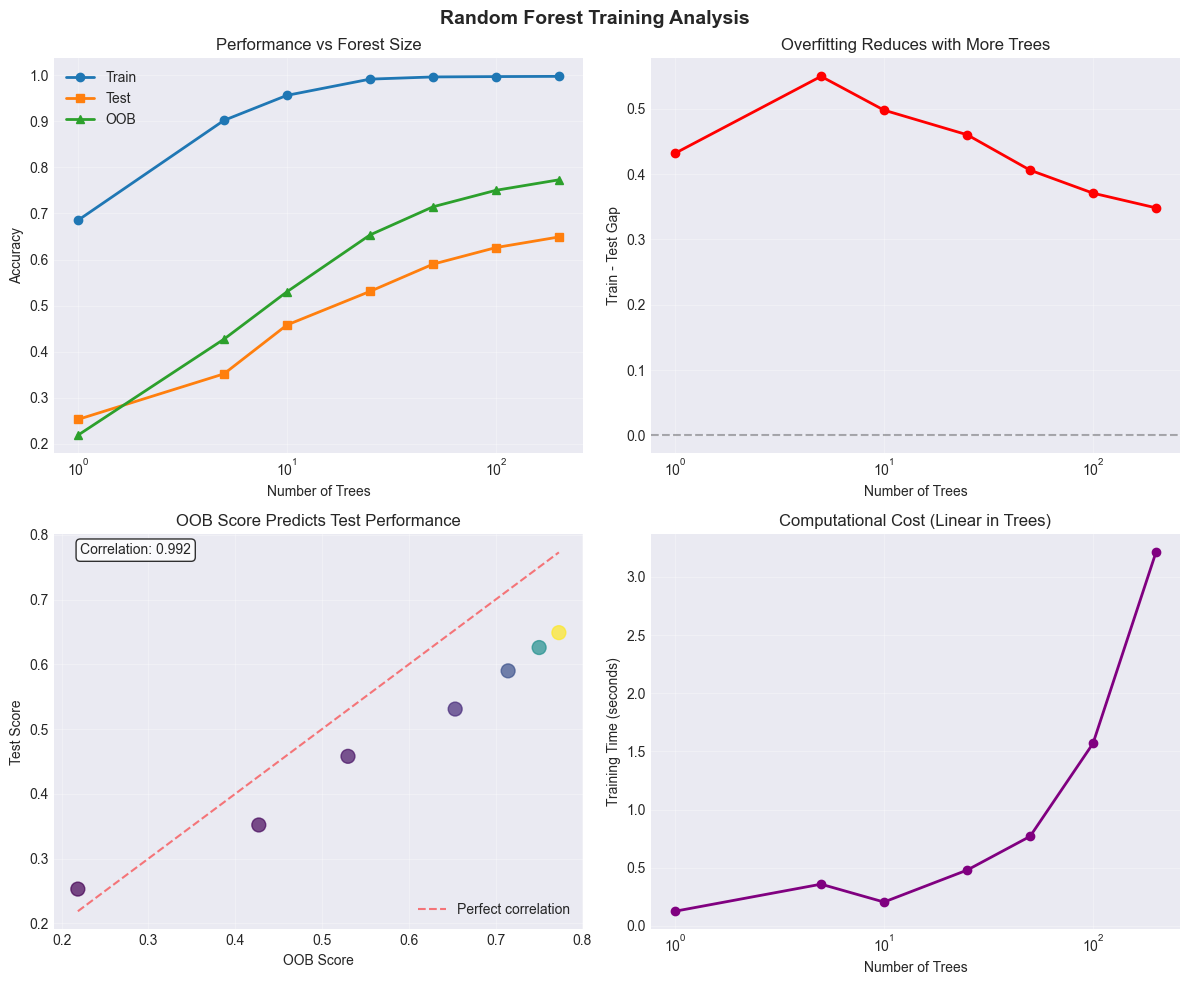

In [11]:
def train_random_forest_analysis(X_train, y_train, X_test, y_test):
    """Train Random Forest with performance analysis"""
    
    n_trees_list = [1, 5, 10, 25, 50, 100, 200]
    
    train_scores = []
    test_scores = []
    oob_scores = []
    train_times = []
    
    print("Training Random Forests with increasing trees...")
    
    for n_trees in n_trees_list:
        start_time = time.time()
        
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=10,
            max_features='sqrt',
            oob_score=True,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        
        train_acc = accuracy_score(y_train, rf.predict(X_train))
        test_acc = accuracy_score(y_test, rf.predict(X_test))
        oob_acc = rf.oob_score_
        
        train_scores.append(train_acc)
        test_scores.append(test_acc)
        oob_scores.append(oob_acc)
        train_times.append(train_time)
        
        print(f"  n_trees={n_trees:3d}: Test={test_acc:.3f}, OOB={oob_acc:.3f}, Time={train_time:.2f}s")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Performance curves
    ax = axes[0, 0]
    ax.plot(n_trees_list, train_scores, 'o-', label='Train', linewidth=2)
    ax.plot(n_trees_list, test_scores, 's-', label='Test', linewidth=2)
    ax.plot(n_trees_list, oob_scores, '^-', label='OOB', linewidth=2)
    ax.set_xlabel('Number of Trees')
    ax.set_ylabel('Accuracy')
    ax.set_title('Performance vs Forest Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    # Overfitting analysis
    ax = axes[0, 1]
    overfitting_gap = np.array(train_scores) - np.array(test_scores)
    ax.plot(n_trees_list, overfitting_gap, 'o-', color='red', linewidth=2)
    ax.set_xlabel('Number of Trees')
    ax.set_ylabel('Train - Test Gap')
    ax.set_title('Overfitting Reduces with More Trees')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # OOB vs Test correlation
    ax = axes[1, 0]
    ax.scatter(oob_scores, test_scores, s=100, alpha=0.7, c=n_trees_list, cmap='viridis')
    ax.plot([min(oob_scores), max(oob_scores)], 
           [min(oob_scores), max(oob_scores)], 
           'r--', alpha=0.5, label='Perfect correlation')
    ax.set_xlabel('OOB Score')
    ax.set_ylabel('Test Score')
    ax.set_title('OOB Score Predicts Test Performance')
    correlation = np.corrcoef(oob_scores, test_scores)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
           transform=ax.transAxes, fontsize=10,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Training time
    ax = axes[1, 1]
    ax.plot(n_trees_list, train_times, 'o-', color='purple', linewidth=2)
    ax.set_xlabel('Number of Trees')
    ax.set_ylabel('Training Time (seconds)')
    ax.set_title('Computational Cost (Linear in Trees)')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    plt.suptitle('Random Forest Training Analysis', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Return best model
    best_rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    best_rf.fit(X_train, y_train)
    
    return best_rf

rf_model = train_random_forest_analysis(X_train, y_train, X_test, y_test)

**Random Forest Insights:**
1. **Performance saturates** around 50-100 trees
2. **OOB closely tracks test error** - free validation!
3. **Overfitting decreases** with more trees (variance reduction)
4. **Linear scaling** - easy to parallelize

## Part 5: Deep Ensembles and Uncertainty


### Deep Ensembles: Diversity + Soft Voting


  Train an ensemble of $M$ independently initialized neural nets on the same feature vectors (e.g., ResNet embeddings). We examine how diversity across models plus soft voting improves accuracy and provides a more reliable prediction than a single model.

**How we create diversity** 
  - Different random initializations: distinct seeds per model.  
  - Stochastic training: shuffled mini-batches and dropout during training.  
  - Independent learners: no weight sharing; each model follows a different optimization trajectory.

**Metrics we report**
  - Per-model test accuracy: $\mathrm{acc}_i$ for model $i$.  
  - Ensemble accuracy: accuracy of the aggregated predictor (see below).  
  - Summary statistics across models: mean $\mu=\frac{1}{M}\sum_{i=1}^M \mathrm{acc}_i$ and standard deviation $\sigma$.  
  - Optional uncertainty: predictive entropy $H[p_{\text{ens}}(y\mid x)] = -\sum_y p_{\text{ens}}(y\mid x)\log p_{\text{ens}}(y\mid x)$.

**How we form the ensemble prediction (soft vote)**
  Let $f_i(x)$ be the logits from model $i$ and $p_i(y\mid x)=\mathrm{softmax}(f_i(x))$. We average probabilities and then take the argmax:  
  - $p_{\text{ens}}(y\mid x) = \frac{1}{M}\sum_{i=1}^{M} p_i(y\mid x)$  
  - $\hat{y}_{\text{ens}}(x) = \arg\max_y\, p_{\text{ens}}(y\mid x)$

Note: This differs from earlier tree ensembles that used hard majority voting on class labels; here we aggregate calibrated probabilities (“soft voting”), which typically yields better performance and smoother confidence estimates.

In [15]:
class SimpleNN(nn.Module):
    """Simple neural network for CIFAR-10"""
    
    def __init__(self, input_dim, hidden_dim=128, output_dim=10, dropout=0.3):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_deep_ensemble(X_train, y_train, X_test, y_test, n_models=5):
    """Train ensemble of neural networks"""
    
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.LongTensor(y_test).to(device)
    
    # Create data loader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    ensemble = []
    test_accuracies = []
    
    print(f"Training deep ensemble with {n_models} neural networks...")
    
    for model_idx in range(n_models):
        torch.manual_seed(model_idx * 100)  # Different initialization
        
        model = SimpleNN(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        # Train for fewer epochs for demo
        for epoch in range(20):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_t)
            _, predicted = torch.max(outputs, 1)
            accuracy = accuracy_score(y_test, predicted.cpu().numpy())
            test_accuracies.append(accuracy)
        
        ensemble.append(model)
        print(f"  Model {model_idx + 1}: Test accuracy = {accuracy:.3f}")
    
    print(f"\nEnsemble statistics:")
    print(f"  Mean accuracy: {np.mean(test_accuracies):.3f}")
    print(f"  Std accuracy: {np.std(test_accuracies):.3f}")
    
    return ensemble, X_test_t, y_test_t

deep_ensemble, X_test_tensor, y_test_tensor = train_deep_ensemble(X_train, y_train, X_test, y_test)

Training deep ensemble with 5 neural networks...
  Model 1: Test accuracy = 0.776
  Model 2: Test accuracy = 0.746
  Model 3: Test accuracy = 0.771
  Model 4: Test accuracy = 0.748
  Model 5: Test accuracy = 0.765

Ensemble statistics:
  Mean accuracy: 0.761
  Std accuracy: 0.012


### Deep Ensemble Uncertainty: Definitions and What to Expect

Let $M$ be the number of models and $C$ the number of classes. For an input $x$:
- Per-model probabilities: $p^{(m)}(y\mid x)=\mathrm{softmax}(f^{(m)}(x))$
- Ensemble mean probability: $\bar{p}(y\mid x)=\frac{1}{M}\sum_{m=1}^{M}p^{(m)}(y\mid x)$

We decompose predictive uncertainty into:
- Total (predictive) uncertainty:
  $$
  H[\bar{p}] \;=\; -\sum_{c=1}^{C}\bar{p}_c\log \bar{p}_c
  $$
- Aleatoric (data) uncertainty (average entropy of members):
  $$
  \bar{H} \;=\; \frac{1}{M}\sum_{m=1}^{M}\Big(-\sum_{c=1}^{C}p^{(m)}_c\log p^{(m)}_c\Big)
  $$
- Epistemic (model) uncertainty (mutual information):
  $$
  I \;=\; H[\bar{p}] - \bar{H}
  $$

**Properties and interpretation:**
- Bounds: $0 \le \bar{H} \le H[\bar{p}] \le \log C$, hence $I\ge 0$ (small negative values can occur numerically).
- High $I$ (epistemic): models disagree; reducible with more data/model capacity; often signals OOD/shift or lack of knowledge.
- High $\bar{H}$ (aleatoric): data is inherently ambiguous/noisy (e.g., cat vs dog); largely irreducible.
- Ensemble prediction (soft vote):
  $$
  \hat{y}_{\text{ens}}(x)=\arg\max_{c}\bar{p}_c
  $$

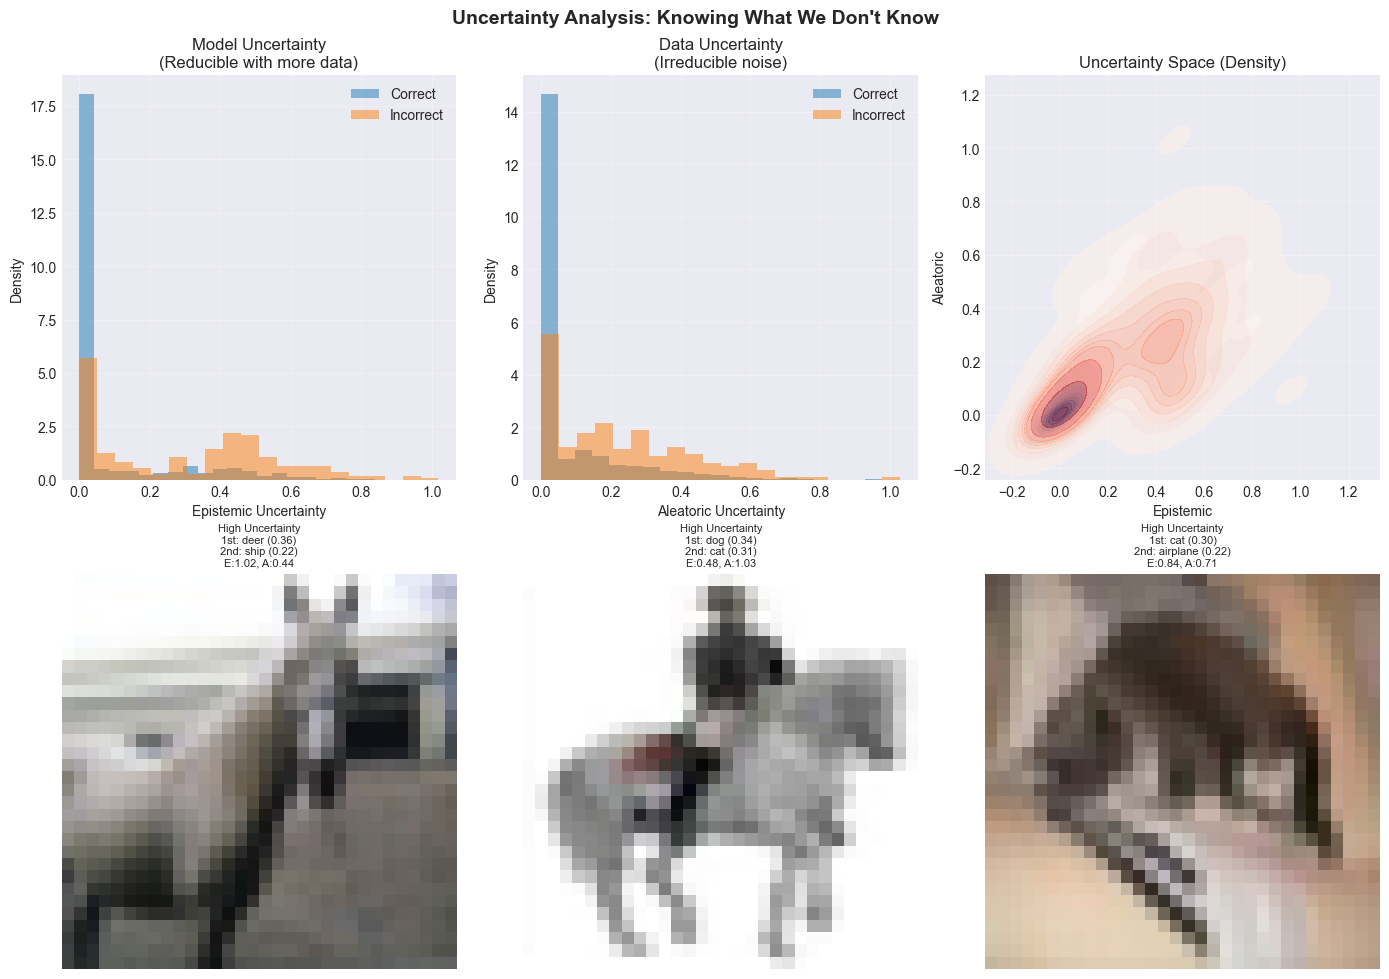


Uncertainty Statistics:
  Correct predictions - Avg epistemic: 0.085
  Incorrect predictions - Avg epistemic: 0.300
  Correlation with errors: High uncertainty = More likely wrong


In [20]:

def analyze_uncertainty(ensemble, X_test_tensor, y_test_tensor, X_test_imgs, class_names):
    """Analyze epistemic and aleatoric uncertainty"""
    
    # Get predictions from all models
    all_probs = []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
    
    all_probs = np.array(all_probs)
    
    # Calculate uncertainties
    mean_probs = np.mean(all_probs, axis=0)
    
    # Total uncertainty (entropy of mean)
    total_uncertainty = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    
    # Aleatoric (average entropy)
    individual_entropies = -np.sum(all_probs * np.log(all_probs + 1e-10), axis=2)
    aleatoric = np.mean(individual_entropies, axis=0)
    
    # Epistemic (total - aleatoric)
    epistemic = total_uncertainty - aleatoric
    
    # Get ensemble predictions
    ensemble_pred = np.argmax(mean_probs, axis=1)
    correct = ensemble_pred == y_test_tensor.cpu().numpy()
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))
    
    # Epistemic uncertainty distribution
    #   Two histograms (density=True): one for correct predictions and one for incorrect.
    #   Expectation: incorrect samples tend to have higher epistemic uncertainty. 
    #        This captures disagreement/instability across models and typically 
    #        shrinks as data/model capacity increase.
    ax = axes[0, 0]
    ax.hist(epistemic[correct], alpha=0.5, label='Correct', bins=20, density=True)
    ax.hist(epistemic[~correct], alpha=0.5, label='Incorrect', bins=20, density=True)
    ax.set_xlabel('Epistemic Uncertainty')
    ax.set_ylabel('Density')
    ax.set_title('Model Uncertainty\n(Reducible with more data)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Aleatoric uncertainty distribution
    #     Two histograms for aleatoric uncertainty on correct vs incorrect.
    #     Expectation: hard/ambiguous or noisy samples (e.g., visually confusing classes) 
    #     show higher aleatoric uncertainty. It may be elevated for both correct and incorrect 
    #     cases when the image itself is inherently ambiguous.
    ax = axes[0, 1]
    ax.hist(aleatoric[correct], alpha=0.5, label='Correct', bins=20, density=True)
    ax.hist(aleatoric[~correct], alpha=0.5, label='Incorrect', bins=20, density=True)
    ax.set_xlabel('Aleatoric Uncertainty')
    ax.set_ylabel('Density')
    ax.set_title('Data Uncertainty\n(Irreducible noise)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2D uncertainty space (density contours to reduce overlap)
    ax = axes[0, 2]
    df_unc = pd.DataFrame({
        'Epistemic': epistemic,
        'Aleatoric': aleatoric,
        'Correct': correct
    })
    sns.kdeplot(
        data=df_unc[df_unc['Correct']],
        x='Epistemic', y='Aleatoric',
        fill=True, levels=10, thresh=0.02, cmap='Blues', alpha=0.6, ax=ax, label='Correct'
    )
    sns.kdeplot(
        data=df_unc[~df_unc['Correct']],
        x='Epistemic', y='Aleatoric',
        fill=True, levels=10, thresh=0.02, cmap='Reds', alpha=0.5, ax=ax, label='Incorrect'
    )
    ax.set_xlabel('Epistemic')
    ax.set_ylabel('Aleatoric')
    ax.set_title('Uncertainty Space (Density)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Show high uncertainty examples
    high_uncertainty_idx = np.argsort(total_uncertainty)[-3:]
    
    for i, idx in enumerate(high_uncertainty_idx):
        ax = axes[1, i]
        
        img = X_test_imgs[idx].transpose((1, 2, 0))
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Get top 2 predictions
        top2_idx = np.argsort(mean_probs[idx])[-2:][::-1]
        
        title = f'High Uncertainty\n'
        title += f'1st: {class_names[top2_idx[0]]} ({mean_probs[idx, top2_idx[0]]:.2f})\n'
        title += f'2nd: {class_names[top2_idx[1]]} ({mean_probs[idx, top2_idx[1]]:.2f})\n'
        title += f'E:{epistemic[idx]:.2f}, A:{aleatoric[idx]:.2f}'
        
        ax.set_title(title, fontsize=8)
        ax.axis('off')
    
    plt.suptitle('Uncertainty Analysis: Knowing What We Don\'t Know', 
                fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nUncertainty Statistics:")
    print(f"  Correct predictions - Avg epistemic: {np.mean(epistemic[correct]):.3f}")
    print(f"  Incorrect predictions - Avg epistemic: {np.mean(epistemic[~correct]):.3f}")
    print(f"  Correlation with errors: High uncertainty = More likely wrong")
    
    return epistemic, aleatoric, ensemble_pred

epistemic_unc, aleatoric_unc, ensemble_preds = analyze_uncertainty(
    deep_ensemble, X_test_tensor, y_test_tensor, X_test_imgs, class_names
)

**Uncertainty Insights:**
- **Incorrect predictions have higher uncertainty** - the model "knows" when it's unsure
- **High uncertainty images** are typically ambiguous (could be multiple classes)
- **Epistemic vs Aleatoric**: Epistemic can be reduced with more training data, aleatoric cannot

### Out-of-Distribution (OOD) Detection with Deep Ensembles

**Goal:** Compare in-distribution vs OOD inputs using ensemble confidence and agreement. OOD here = Gaussian noise features and heavily corrupted real features.

**Ensemble probabilities**  
  For model indices $m=1…M$, let probabilities be $p^{(m)}(y|x)$. The ensemble mean:
  $$
  \bar{p}(y\mid x)=\frac{1}{M}\sum_{m=1}^{M}p^{(m)}(y\mid x)
  $$

  - Confidence (max soft-vote):
    $$
    \mathrm{conf}(x)=\max_{c}\;\bar{p}_c(x)
    $$
  - Agreement (vote concentration):
    $$
    \mathrm{agr}(x)=\frac{1}{M}\max_{y}\sum_{m=1}^{M}\mathbf{1}\!\left[\arg\max_{c}\,p^{(m)}_c(x)=y\right]
    $$

**What to expect in histograms**  
  - In-distribution: higher confidence and higher agreement (distributions shifted right).  
  - OOD: lower confidence and lower agreement (distributions shifted left).



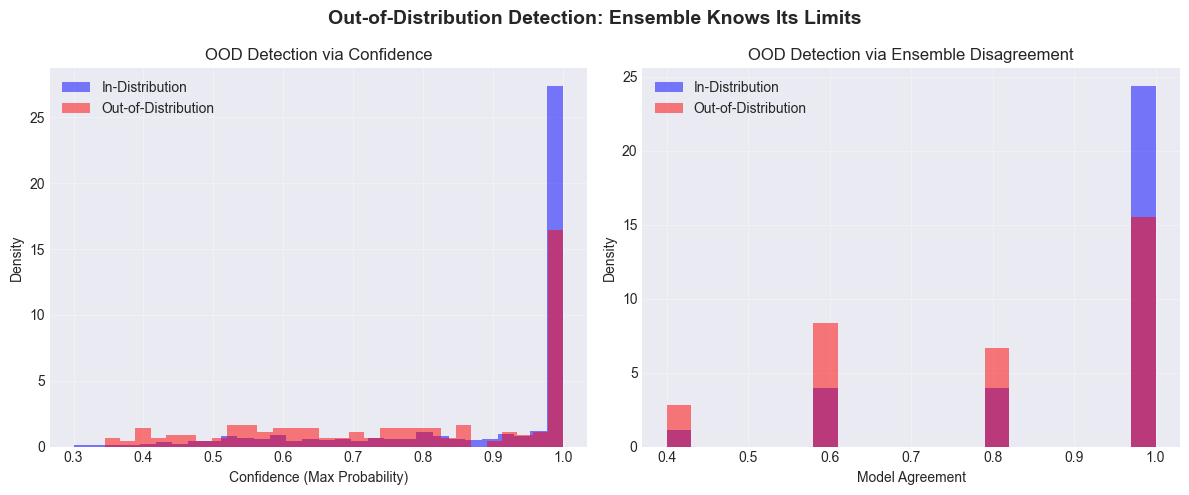


OOD Detection Results:
  In-distribution - Avg confidence: 0.897
  Out-of-distribution - Avg confidence: 0.785
  In-distribution - Avg agreement: 0.909
  Out-of-distribution - Avg agreement: 0.809


In [21]:
def test_ood_detection(ensemble, X_test_tensor, X_test):
    """Test if ensemble can detect out-of-distribution samples"""
    
    # Create OOD samples (corrupted and random noise)
    n_ood = 200
    
    # Type 1: Random Gaussian noise
    noise_ood = np.random.randn(n_ood//2, X_test.shape[1]) * 2
    
    # Type 2: Heavily corrupted real images
    corrupted = X_test[:n_ood//2].copy()
    corrupted += np.random.randn(*corrupted.shape) * 3
    
    X_ood = np.vstack([noise_ood, corrupted])
    X_ood_tensor = torch.FloatTensor(X_ood).to(device)
    
    # Calculate ensemble predictions and confidence
    def get_confidence_and_agreement(X_tensor):
        all_probs = []
        all_preds = []
        
        for model in ensemble:
            model.eval()
            with torch.no_grad():
                outputs = model(X_tensor)
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_probs.append(probs.cpu().numpy())
                all_preds.append(preds.cpu().numpy())
        
        all_probs = np.array(all_probs)
        all_preds = np.array(all_preds)
        
        # Mean confidence (max probability)
        mean_probs = np.mean(all_probs, axis=0)
        confidence = np.max(mean_probs, axis=1)
        
        # Agreement (how often models agree)
        agreement = np.zeros(len(X_tensor))
        for i in range(len(X_tensor)):
            pred_counts = np.bincount(all_preds[:, i])
            agreement[i] = np.max(pred_counts) / len(ensemble)
        
        return confidence, agreement
    
    # Get metrics for in-distribution and OOD
    in_conf, in_agree = get_confidence_and_agreement(X_test_tensor)
    ood_conf, ood_agree = get_confidence_and_agreement(X_ood_tensor)
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confidence distributions
    ax1.hist(in_conf, bins=30, alpha=0.5, label='In-Distribution', 
            density=True, color='blue')
    ax1.hist(ood_conf, bins=30, alpha=0.5, label='Out-of-Distribution', 
            density=True, color='red')
    ax1.set_xlabel('Confidence (Max Probability)')
    ax1.set_ylabel('Density')
    ax1.set_title('OOD Detection via Confidence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Agreement distributions
    ax2.hist(in_agree, bins=20, alpha=0.5, label='In-Distribution', 
            density=True, color='blue')
    ax2.hist(ood_agree, bins=20, alpha=0.5, label='Out-of-Distribution', 
            density=True, color='red')
    ax2.set_xlabel('Model Agreement')
    ax2.set_ylabel('Density')
    ax2.set_title('OOD Detection via Ensemble Disagreement')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Out-of-Distribution Detection: Ensemble Knows Its Limits', 
                fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nOOD Detection Results:")
    print(f"  In-distribution - Avg confidence: {np.mean(in_conf):.3f}")
    print(f"  Out-of-distribution - Avg confidence: {np.mean(ood_conf):.3f}")
    print(f"  In-distribution - Avg agreement: {np.mean(in_agree):.3f}")
    print(f"  Out-of-distribution - Avg agreement: {np.mean(ood_agree):.3f}")

test_ood_detection(deep_ensemble, X_test_tensor, X_test)

**OOD Detection Success:**
- Out-of-distribution samples show **lower confidence** and **lower agreement**
- This enables safe deployment: flag uncertain predictions for human review
- Critical for real-world applications where novel inputs are common


## Conclusion and Summary
### Key Takeaways

Through hands-on experiments with CIFAR-10, we've demonstrated that:

1. **Ensemble Diversity is Key**: Different models make different errors that cancel out when combined
2. **Random Forests**: Bootstrap + feature randomness creates robust predictions with minimal overfitting
3. **Boosting**: Sequential learning automatically focuses on hard examples
4. **Deep Ensembles**: Provide calibrated uncertainty estimates - knowing what you don't know
5. **Practical Impact**: All methods significantly outperform single models
